In [1]:
%load_ext autoreload
%autoreload 2

from pandas_profiling import ProfileReport
%pylab inline

import warnings
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_train = pd.read_csv('./data/train_2016_v2.csv')

In [3]:
dtypes = {
    'parcelid': int,
    'airconditioningtypeid': str,
    'architecturalstyletypeid': str,
    'buildingclasstypeid': str,
    'buildingqualitytypeid': str,
    'decktypeid': str,
    'heatingorsystemtypeid': str,
    'pooltypeid10': str,
    'pooltypeid2': str,
    'pooltypeid7': str,
    'regionidcity': str,
    'regionidcounty': str,
    'regionidneighborhood': str,
    'regionidzip': str,
    'typeconstructiontypeid': str,
    'hashottuborspa': str,
    'propertycountylandusecode': str,
    'propertylandusetypeid': str,
    'propertyzoningdesc': str,
    'rawcensustractandblock': str,
    'fireplaceflag': str,
    'taxdelinquencyflag': str,
    'censustractandblock': str,
}

props_df = pd.read_csv('./data/properties_2016.csv', dtype=dtypes)

dtypes.update({
    'fireplacecnt': int,
    'fullbathcnt': int,
    'garagecarcnt': int,
    'poolcnt': int,
    'threequarterbathnbr': int,
    'unitcnt': int,
    'yearbuilt': int,
    'numberofstories': int,
    'structuretaxvaluedollarcnt': int,
    'taxvaluedollarcnt': int,
    'landtaxvaluedollarcnt': int,
    'taxdelinquencyyear': int,
    'roomcnt': int,
    'bedroomcnt': int,
    'assessmentyear': int,
    'fips': int,
})

In [4]:
df_train = df_train.merge(props_df, on='parcelid', how='left')
df_train.head()

,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1,NaN,NaN,2.0,3.0,NaN,4,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,60371066461001
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1,NaN,NaN,3.0,2.0,NaN,4,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,60374638003004
3,12643413,0.0218,2016-01-02,1,NaN,NaN,2.0,2.0,NaN,4,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,60372963002002
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,60590423381006


In [5]:
def log_transf(df):
    if 'structuretaxvaluedollarcnt' in df.columns:
        df.loc[:, 'structuretaxvaluedollarcnt'] = np.log1p(df.structuretaxvaluedollarcnt).copy()
    if 'taxvaluedollarcnt' in df.columns:
        df.loc[:, 'taxvaluedollarcnt'] = np.log1p(df.taxvaluedollarcnt).copy()
    if 'calculatedfinishedsquarefeet' in df.columns:
        df.loc[:, 'calculatedfinishedsquarefeet'] = np.log1p(df.calculatedfinishedsquarefeet).copy()
    if 'lotsizesquarefeet' in df.columns:
        df.loc[:, 'lotsizesquarefeet'] = np.log1p(df.lotsizesquarefeet).copy()
    if 'finishedsquarefeet12' in df.columns:
        df.loc[:, 'finishedsquarefeet12'] = np.log1p(df.finishedsquarefeet12).copy()
    return df

def preprocess(df, rejected_cols=[]):
    drop_cols = set(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc',
                     'propertycountylandusecode']+rejected_cols)
    df = df.copy()
    df['latitude'] = df.latitude / 1e6
    df['longitude'] = df.longitude / 1e6
    
    # From https://www.kaggle.com/nikunjm88/creating-additional-features
    #life of property
    df['N-life'] = 2018 - df['yearbuilt']

    #proportion of living area
    df['N-LivingAreaProp'] = df['calculatedfinishedsquarefeet']/df['lotsizesquarefeet']
    df['N-LivingAreaProp2'] = df['N-LivingAreaProp']**2
    df['N-LivingAreaProp3'] = df['N-LivingAreaProp']**3
    df['N-LivingAreaProp-2'] = df['finishedsquarefeet12']/df['finishedsquarefeet15']

    #Amout of extra space
    df['N-ExtraSpace'] = df['lotsizesquarefeet'] - df['calculatedfinishedsquarefeet'] 
    df['N-ExtraSpace-2'] = df['finishedsquarefeet15'] - df['finishedsquarefeet12'] 

    #Total number of rooms
    df['N-TotalRooms'] = df['bathroomcnt']*df['bedroomcnt']

    #Average room size
    df['N-AvRoomSize'] = df['calculatedfinishedsquarefeet']/df['roomcnt'] 

    # Number of Extra rooms
    df['N-ExtraRooms'] = df['roomcnt'] - df['N-TotalRooms'] 

    #Ratio of the built structure value to land area
    df['N-ValueProp'] = df['structuretaxvaluedollarcnt']/df['landtaxvaluedollarcnt']

    df['N-ValueProp2'] = df['N-ValueProp']**2
    df['N-ValueProp3'] = df['N-ValueProp']**3
    
    #Does property have a garage, pool or hot tub and AC?
    df['N-GarPoolAC'] = ((df['garagecarcnt'] > 0) &
                         (df['pooltypeid10'] != '0') &
                         (df['airconditioningtypeid'] != '5'))*1 
    drop_cols.add('garagecarcnt')
    
    df["N-location"] = df["latitude"] + df["longitude"]
    df["N-location-2"] = df["latitude"] * df["longitude"]
    df["N-location-2round"] = df["N-location-2"].round(-4)

    df["N-latitude-round"] = df["latitude"].round(-4)
    df["N-longitude-round"] = df["longitude"].round(-4)

    #Ratio of tax of property over parcel
    df['N-ValueRatio'] = df['taxvaluedollarcnt']/df['taxamount']
    df['N-ValueRatio2'] = df['N-ValueRatio']**2
    df['N-ValueRatio3'] = df['N-ValueRatio']**3

    #TotalTaxScore
    df['N-TaxScore'] = df['taxvaluedollarcnt']*df['taxamount']
    df['N-TaxScore2'] = df['N-TaxScore']**2
    df['N-TaxScore3'] = df['N-TaxScore']**3
    
    #polnomials of tax delinquency year
    df["N-taxdelinquencyyear-2"] = df["taxdelinquencyyear"] ** 2
    df["N-taxdelinquencyyear-3"] = df["taxdelinquencyyear"] ** 3

    #Length of time since unpaid taxes
    df['N-life'] = 2018 - df['taxdelinquencyyear']

    #Number of properties in the zip
    zip_count = df['regionidzip'].value_counts().to_dict()
    df['N-zip_count'] = df['regionidzip'].map(zip_count)

    #Number of properties in the city
    city_count = df['regionidcity'].value_counts().to_dict()
    df['N-city_count'] = df['regionidcity'].map(city_count)

    #Number of properties in the city
    region_count = df['regionidcounty'].value_counts().to_dict()
    df['N-county_count'] = df['regionidcounty'].map(city_count)

    #Indicator whether it has AC or not
    df['N-ACInd'] = (df['airconditioningtypeid']!=5)*1

    #Indicator whether it has Heating or not 
    df['N-HeatInd'] = (df['heatingorsystemtypeid']!=13)*1

    #There's 25 different property uses - let's compress them down to 4 categories
    df['N-PropType'] = df.propertylandusetypeid.replace({
        31 : "Mixed",
        46 : "Other",
        47 : "Mixed",
        246 : "Mixed",
        247 : "Mixed",
        248 : "Mixed",
        260 : "Home",
        261 : "Home",
        262 : "Home",
        263 : "Home",
        264 : "Home",
        265 : "Home",
        266 : "Home",
        267 : "Home",
        268 : "Home",
        269 : "Not Built",
        270 : "Home",
        271 : "Home",
        273 : "Home",
        274 : "Other",
        275 : "Home",
        276 : "Home",
        279 : "Home",
        290 : "Not Built",
        291 : "Not Built"
    })
    drop_cols.add('propertylandusetypeid')


    #polnomials of the variable
    df["N-structuretaxvaluedollarcnt-2"] = df["structuretaxvaluedollarcnt"] ** 2
    df["N-structuretaxvaluedollarcnt-3"] = df["structuretaxvaluedollarcnt"] ** 3

    #Average structuretaxvaluedollarcnt by city
    group = df.groupby('regionidcity')['structuretaxvaluedollarcnt'].aggregate('mean').to_dict()
    df['N-Avg-structuretaxvaluedollarcnt'] = df['regionidcity'].map(group)

    #Deviation away from average
    df['N-Dev-structuretaxvaluedollarcnt'] = (abs((df['structuretaxvaluedollarcnt'] -
                                                   df['N-Avg-structuretaxvaluedollarcnt'])) /
                                              df['N-Avg-structuretaxvaluedollarcnt'])

    df['fireplaceflag'] = df.fireplaceflag == 'True'
    df['taxdelinquencyflag'] = df.taxdelinquencyflag == 'Y'
    df['hashottuborspa'] = df.hashottuborspa == 'true'

    df['fireplacecnt'] = df.fireplacecnt.fillna(0).astype(int)
    df['fullbathcnt'] = df.fullbathcnt.fillna(0).astype(int)
    df['garagecarcnt'] = df.garagecarcnt.fillna(0).astype(int)
    df['poolcnt'] = df.poolcnt.fillna(0).astype(int)
    df['threequarterbathnbr'] = df.threequarterbathnbr.fillna(0).astype(int)
    df['unitcnt'] = df.threequarterbathnbr.fillna(0).astype(int)
    df['numberofstories'] = df.numberofstories.fillna(0).astype(int)
    df['numberofstories'] = df.numberofstories.fillna(0).astype(int)
    df['roomcnt'] = df.roomcnt.fillna(0).astype(int)
    df['bedroomcnt'] = df.bedroomcnt.fillna(0).astype(int)
    df['bedroomcnt'] = df.bedroomcnt.fillna(0).astype(int)

    df['fips'] = df.fips.fillna(-1).astype(int)

    df['yearbuilt'] = df.yearbuilt.fillna(np.round(df.yearbuilt.mean())).astype(int)
    df['taxdelinquencyyear'] = df.taxdelinquencyyear.fillna(
        np.round(df.taxdelinquencyyear.mean())
    ).astype(int)
    df['assessmentyear'] = df.assessmentyear.fillna(
        np.round(df.assessmentyear.mean())
    ).astype(int)
    df['structuretaxvaluedollarcnt'] = df.structuretaxvaluedollarcnt.fillna(
        np.round(df.structuretaxvaluedollarcnt.mean())
    ).astype(int)
    df['taxvaluedollarcnt'] = df.taxvaluedollarcnt.fillna(
        np.round(df.taxvaluedollarcnt.mean())
    ).astype(int)
    df['landtaxvaluedollarcnt'] = df.landtaxvaluedollarcnt.fillna(
        np.round(df.landtaxvaluedollarcnt.mean())
    ).astype(int)
    
    # drop columns with std 0
    df = df.drop(['buildingclasstypeid', 'pooltypeid10', 'pooltypeid7',
                  'storytypeid', 'poolcnt', 'assessmentyear'], axis=1, errors='ignore')

    df_cols = df.columns
    df.loc[:, df_cols.str.contains('sqft')] = df.loc[:, df_cols.str.contains('sqft')].fillna(0)
    
    # set nan values in *squarefeet* columns to 0
    df.loc[:, df_cols.str.contains('squarefeet')] = df.loc[:, df_cols.str.contains('squarefeet')].fillna(0)

    
    # fill NaNs in *typeid* columns to -1
    df.loc[:, df_cols.str.contains('typeid')] = df.loc[:, df_cols.str.contains('typeid')].fillna(-1)
    
    # set nan values in *cnt* columns to 0
    df.loc[:, df_cols.str.contains('cnt')] = df.loc[:, df_cols.str.contains('cnt')].fillna(0)
    
    # set NaNs in rest of counts/sums columns to 0
    cols = ['calculatedbathnbr', 'poolsizesum', 'threequarterbathnbr', 'numberofstories']
    df.loc[:, cols] = df.loc[:, cols].fillna(0)

    # set NaNs in rest of id/code columns to 0
    cols = ['regionidcity', 'regionidneighborhood', 'regionidzip', 'censustractandblock']
    df.loc[:, cols] = df.loc[:, cols].fillna(-1)

    # set NaNs in rest of dates columns to mean
    cols = ['yearbuilt', 'taxamount', 'taxdelinquencyyear']
    df.loc[:, cols] = df.loc[:, cols].fillna(df.loc[:, cols].mean())

    drop_cols &= set(df.columns)
    X = df.drop(drop_cols, axis=1).copy()
    y = None
    if 'logerror' in df.columns:
        y = df['logerror'].values.copy()

    for c in X.columns:
        if X[c].dtype == 'object':
            lbl = LabelEncoder()
            X[c] = lbl.fit_transform(list(X[c].values))

    X = log_transf(X)
    X['calculatedfinishedsquarefeet2'] = X['calculatedfinishedsquarefeet']**2
    X['calculatedfinishedsquarefeet3'] = X['calculatedfinishedsquarefeet']**3
    
    return X, y

In [6]:
df_train1, df_test =\
    train_test_split(df_train, test_size=0.2, random_state=0, stratify=np.sign(df_train.logerror))

In [7]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    report = ProfileReport(df_train1.sample(frac=0.5))
report.to_file('zillow_report.html')
report

Number of variables,61
Number of observations,36110
Total Missing (%),39.6%
Total size in memory,16.8 MiB
Average record size in memory,488.0 B
Numeric,28
Categorical,23
Date,0
Text (Unique),0
Rejected,10
Distinct count,6


In [8]:
report.get_rejected_variables()

['calculatedbathnbr',
 'finishedsquarefeet12',
 'finishedsquarefeet13',
 'finishedsquarefeet15',
 'finishedsquarefeet50',
 'finishedsquarefeet6',
 'fullbathcnt',
 'landtaxvaluedollarcnt',
 'taxamount']

In [9]:
rejected_cols1 = [
    'calculatedbathnbr',
    'finishedsquarefeet12',
    'finishedsquarefeet13',
    'finishedsquarefeet15',
    'finishedsquarefeet50',
    'finishedsquarefeet6',
    'fullbathcnt',
    'landtaxvaluedollarcnt',
    'taxamount'
]
X_train, y_train = preprocess(df_train1, rejected_cols1)
X_test, y_test = preprocess(df_test, rejected_cols1)

In [10]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    X_train_report = ProfileReport(X_train)
X_train_report.to_file('X_train_report.html')
X_train_report

Number of variables,78
Number of observations,72220
Total Missing (%),6.9%
Total size in memory,41.5 MiB
Average record size in memory,603.0 B
Numeric,58
Categorical,0
Date,0
Text (Unique),0
Rejected,20
Constant value,1


In [11]:
X_train_report.get_rejected_variables()

['N-LivingAreaProp3',
 'N-TaxScore3',
 'N-ValueProp3',
 'N-ValueRatio3',
 'N-structuretaxvaluedollarcnt-3',
 'N-taxdelinquencyyear-3',
 'calculatedfinishedsquarefeet2',
 'calculatedfinishedsquarefeet3',
 'censustractandblock',
 'typeconstructiontypeid',
 'unitcnt']

In [12]:
rejected_cols2 = [
    'censustractandblock',
    'typeconstructiontypeid',
    'unitcnt'
]
X_train = X_train.drop(rejected_cols2, axis=1)
X_test = X_test.drop(rejected_cols2, axis=1)

In [13]:
sk_params = {
    'boosting_type': 'dart',
    'colsample_bytree': 1,
    'learning_rate': 0.03,
    'max_bin': 500,
    'n_estimators': 300,
    'nthread': -1,
    'num_leaves': 100,
    'objective': 'regression_l1',
    'seed ': 0,
    'silent': False,
    'subsample': 1
}

model = lgb.sklearn.LGBMRegressor(**sk_params)
model.fit(X_train, y_train)

LGBMRegressor(boosting_type='dart', colsample_bytree=1, learning_rate=0.03,
       max_bin=500, max_depth=-1, min_child_samples=10, min_child_weight=5,
       min_split_gain=0, n_estimators=300, nthread=-1, num_leaves=100,
       objective='regression_l1', reg_alpha=0, reg_lambda=0, seed=0,
       seed =0, silent=False, subsample=1, subsample_for_bin=50000,
       subsample_freq=1)

/home/mtambos/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


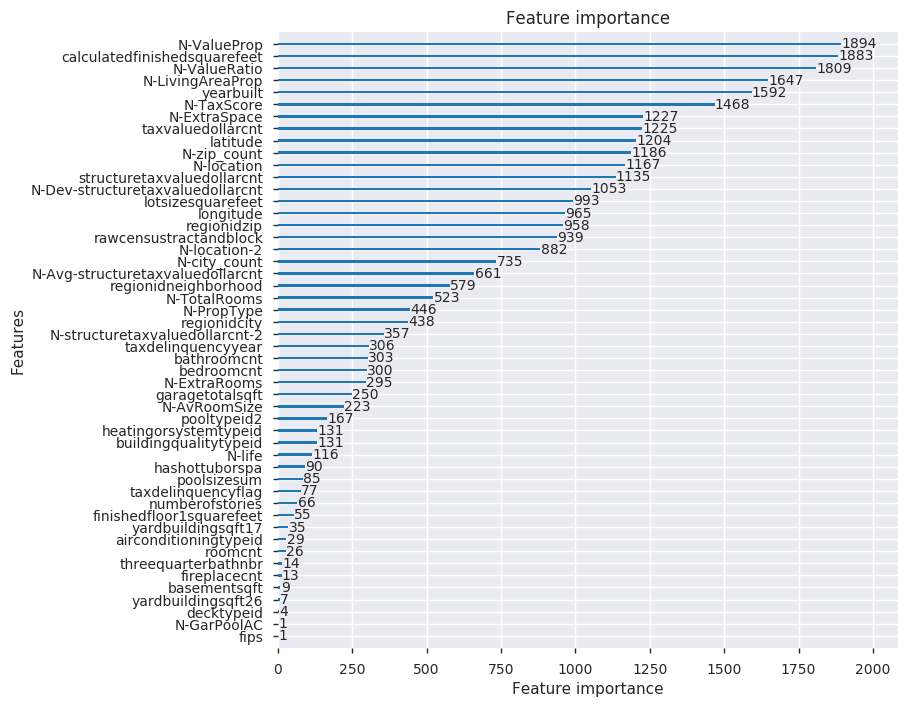

In [14]:
ax = plt.figure(figsize=(8, 8)).gca()
lgb.plotting.plot_importance(model, ax=ax)

In [22]:
dtrain2 = lgb.Dataset(X_train, label=y_train)

params = {
    'boosting_type': 'gbdt',
    'colsample_bytree': 0.98714654768591381,
    'learning_rate': 0.029070156082529032,
    'nthread': -1,
    'num_leaves': 119,
    'objective': 'regression_l1',
    'seed ': 0,
    'subsample': 0.93974756926501701
}


hist = lgb.cv(params=params, train_set=dtrain2, metrics='mae', num_boost_round=1000, early_stopping_rounds=100)
hist

/home/mtambos/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:597: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


{'l1-mean': [0.067642195436762947,
  0.067582314988882577,
  0.067526760566164107,
  0.067474427301316781,
  0.067428792010537114,
  0.067385017219966453,
  0.067343916066115284,
  0.067307282000315549,
  0.067269060313157741,
  0.067234359861583839,
  0.067204778429448109,
  0.067174159474707257,
  0.067146849944626566,
  0.067121623671519665,
  0.067096921859597772,
  0.067073346127263761,
  0.067052094427334924,
  0.067031042752396824,
  0.067009791748247588,
  0.066991566836860375,
  0.066975380457595296,
  0.066960743772150597,
  0.066945975644853939,
  0.066929249252174194,
  0.066914932351559875,
  0.066898395461444965,
  0.066883572108362752,
  0.066869736668513757,
  0.066855431762201961,
  0.066844618248687274,
  0.066836460504608022,
  0.066825222584462177,
  0.066815288145358503,
  0.066804063046889239,
  0.066794972273964651,
  0.066787090734226368,
  0.066779917676632092,
  0.066771644902596169,
  0.066764140075175921,
  0.066755746052036394,
  0.066747375442808468,
  0.0

In [26]:
cv_score = cross_val_score(lgb.sklearn.LGBMRegressor(**sk_params), X_train, y_train,
                           cv=10, scoring='neg_mean_absolute_error', verbose=1)
cv_score.mean(), cv_score.std()*2

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   49.4s finished


(-0.067158015328192919, 0.0024140307946498548)

# Submission

In [38]:
subm_df = pd.read_csv('./data/sample_submission.csv')

In [35]:
X, y = preprocess(df_train, rejected_cols1 + rejected_cols2)

model = lgb.sklearn.LGBMRegressor(**sk_params)
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', colsample_bytree=0.9871465476859138,
       learning_rate=0.029070156082529032, max_bin=255, max_depth=-1,
       min_child_samples=10, min_child_weight=5, min_split_gain=0,
       n_estimators=92, nthread=-1, num_leaves=119,
       objective='regression_l1', reg_alpha=0, reg_lambda=0, seed=0,
       seed =0, silent=False, subsample=0.939747569265017,
       subsample_for_bin=50000, subsample_freq=1)

In [41]:
test_df = props_df.loc[props_df.parcelid.isin(subm_df.ParcelId)]
test_df, _ = preprocess(test_df, rejected_cols1 + rejected_cols2)
test_df.head()

,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingqualitytypeid,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,fips,...,N-TaxScore,N-taxdelinquencyyear-2,N-zip_count,N-city_count,N-county_count,N-ACInd,N-HeatInd,N-structuretaxvaluedollarcnt-2,N-Avg-structuretaxvaluedollarcnt,N-Dev-structuretaxvaluedollarcnt
0,0,0,0.0,0.0,0,0,0,0.0,0.000000,6037,...,NaN,NaN,8496.0,7506.0,NaN,1,1,0.000000e+00,375668.547481,0.000000
1,0,0,0.0,0.0,0,0,0,0.0,0.000000,6037,...,NaN,NaN,8496.0,7506.0,NaN,1,1,0.000000e+00,375668.547481,0.000000
2,0,0,0.0,0.0,0,0,0,0.0,11.198585,6037,...,2.939897e+10,NaN,9437.0,11686.0,NaN,1,1,4.234834e+11,145331.096424,3.477748
3,0,0,0.0,0.0,0,10,0,0.0,8.530899,6037,...,1.684069e+10,NaN,7916.0,670925.0,NaN,1,1,3.264363e+11,182727.848429,2.126759
4,0,0,0.0,0.0,0,0,0,0.0,7.482682,6037,...,2.481810e+09,NaN,7725.0,670925.0,NaN,1,1,3.755689e+10,182727.848429,0.060572


In [42]:
y_pred = model.predict(test_df)

In [44]:
for c in subm_df.columns[1:]:
    subm_df[c] = y_pred
subm_df

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,-0.000551,-0.000551,-0.000551,-0.000551,-0.000551,-0.000551
1,10759547,0.008192,0.008192,0.008192,0.008192,0.008192,0.008192
2,10843547,0.037517,0.037517,0.037517,0.037517,0.037517,0.037517
3,10859147,0.050030,0.050030,0.050030,0.050030,0.050030,0.050030
4,10879947,0.034216,0.034216,0.034216,0.034216,0.034216,0.034216
5,10898347,0.080193,0.080193,0.080193,0.080193,0.080193,0.080193
6,10933547,0.007837,0.007837,0.007837,0.007837,0.007837,0.007837
7,10940747,0.053323,0.053323,0.053323,0.053323,0.053323,0.053323
8,10954547,-0.002736,-0.002736,-0.002736,-0.002736,-0.002736,-0.002736
9,10976347,0.026618,0.026618,0.026618,0.026618,0.026618,0.026618


In [45]:
subm_df.to_csv('combined_lgbm.csv', index=False, float_format='%.4f')